# Cleaned Notebook: Forecasting Monthly EV Sales
This notebook contains only the essential code and explanations for walk-forward validation and forecasting using various models (Linear Regression, ElasticNet, ARIMA, ARIMAX, XGBoost) on monthly EV sales data. All duplicate imports, redundant code, and repeated cells have been removed for clarity and maintainability.

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

In [5]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

## Feature Sets

In [ ]:
lag_time_features = [f'TVV_Lag{i}' for i in range(1, 7)] + ['year', 'month', 'quarter']
feature_sets = {
    'Lag Only': lag_time_features,
    'All Features': [col for col in df_lagged.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]


}


# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features


## Walk-Forward Validation Functions

In [14]:
def walk_forward_validation(df, features, target_col, model_fn, forecast_horizon=1):
    X = df[features].values
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions, actuals = [], []
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]
        X_test = X[i].reshape(1, -1)
        y_test = y[i + forecast_horizon - 1]
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) 
    return mae, rmse, r2, mape, predictions, actuals

XGBoost (Lag Only) [Validation]: MAPE=0.3492, MAE=3705.62, RMSE=5631.43, R²=0.288


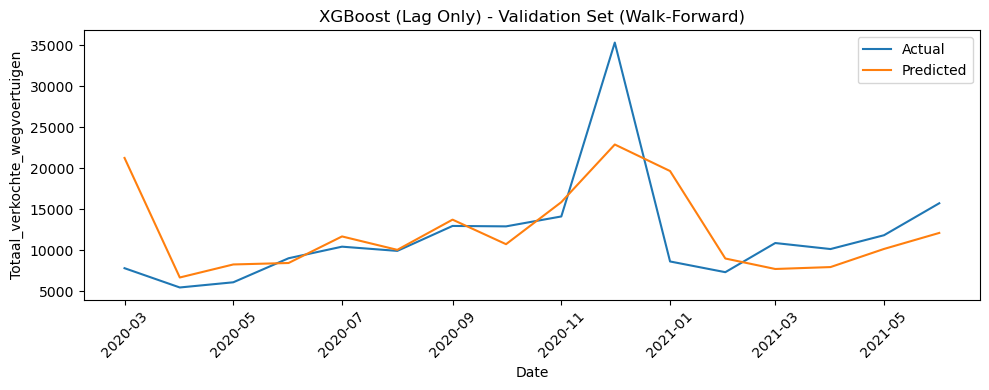

XGBoost (All Features) [Validation]: MAPE=0.4184, MAE=4780.07, RMSE=6837.94, R²=-0.049


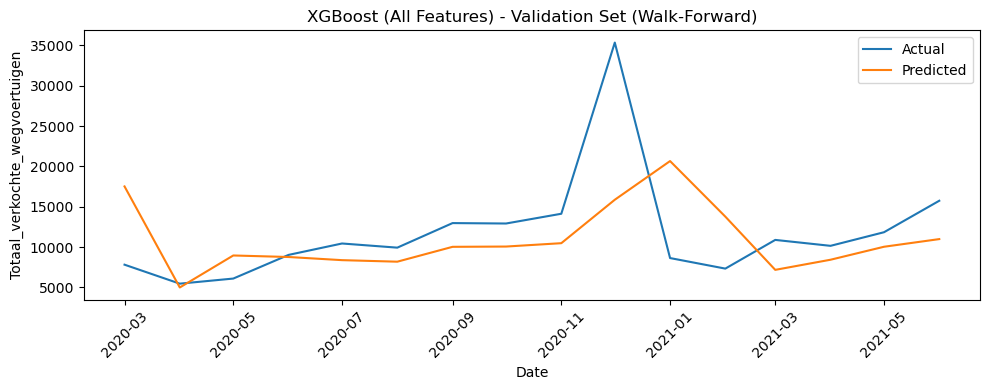

Linear Regression (Lag Only) [Validation]: MAPE=1.2412, MAE=10877.69, RMSE=15203.01, R²=-4.186


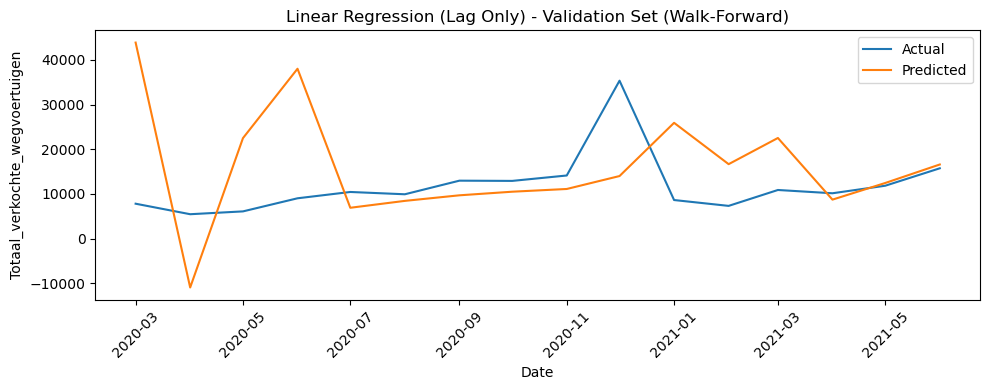

Linear Regression (All Features) [Validation]: MAPE=1.0275, MAE=9260.30, RMSE=13229.15, R²=-2.927


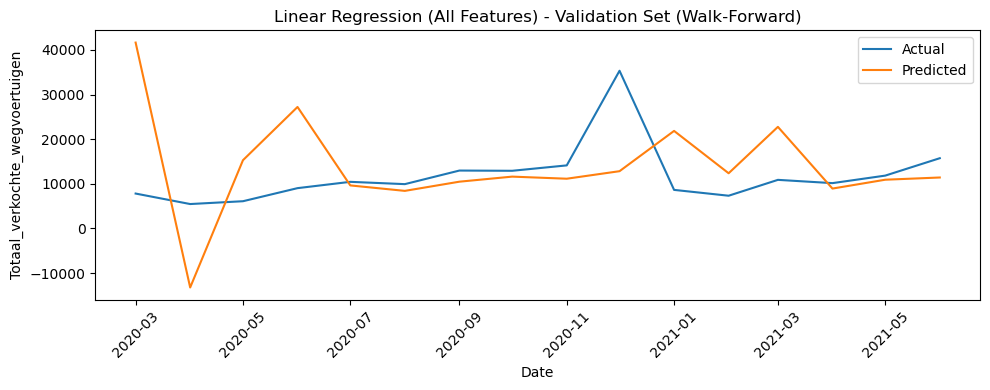

In [51]:

def walk_forward_validation_with_val(df, features, target_col, model_fn, forecast_horizon=1, val_frac=0.1):
    """
    Walk-forward validation with a validation set (inline with time series).
    - The last val_frac of the training period is used as validation.
    - The rest is used for training.
    - Test set is not touched.
    """
    X = df[features].values
    y = df[target_col].values
    n = len(df)
    initial_train_size = int(n * 0.8)
    val_size = int(initial_train_size * val_frac)
    train_size = initial_train_size - val_size

    # Indices for splits
    train_idx = np.arange(train_size)
    val_idx = np.arange(train_size, initial_train_size)
    test_idx = np.arange(initial_train_size, n)

    # --- Validation Walk-Forward ---
    val_predictions, val_actuals = [], []
    for i in range(len(val_idx)):
        # Use all train data + val data up to i for training
        idx = train_size + i
        X_train = X[:idx]
        y_train = y[:idx]
        X_val = X[idx].reshape(1, -1)
        y_val = y[idx]
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)[0]
        val_predictions.append(y_pred)
        val_actuals.append(y_val)
    val_predictions = np.array(val_predictions)
    val_actuals = np.array(val_actuals)
    val_mae = mean_absolute_error(val_actuals, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
    val_r2 = r2_score(val_actuals, val_predictions)
    val_mape = mean_absolute_percentage_error(val_actuals, val_predictions)

    # --- Test Walk-Forward (optional, after tuning) ---
    # You can repeat the same logic for the test set if needed

    return val_mae, val_rmse, val_r2, val_mape, val_predictions, val_actuals, df.iloc[val_idx]['Periode']

# Example usage:
for label, features in feature_sets.items():
    val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, val_dates = walk_forward_validation_with_val(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"))
    print(f"XGBoost ({label}) [Validation]: MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(val_dates, val_actuals, label='Actual')
    plt.plot(val_dates, val_preds, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.title(f'XGBoost ({label}) - Validation Set (Walk-Forward)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
for label, features in feature_sets.items():
    val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, val_dates = walk_forward_validation_with_val(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression())
    print(f"Linear Regression ({label}) [Validation]: MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(val_dates, val_actuals, label='Actual')
    plt.plot(val_dates, val_preds, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.title(f'Linear Regression ({label}) - Validation Set (Walk-Forward)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Linear Regression: Lag Only vs All Features

Linear Regression (Lag Only): MAPE=0.1133, MAE=2537.26, RMSE=3483.25, R²=0.688


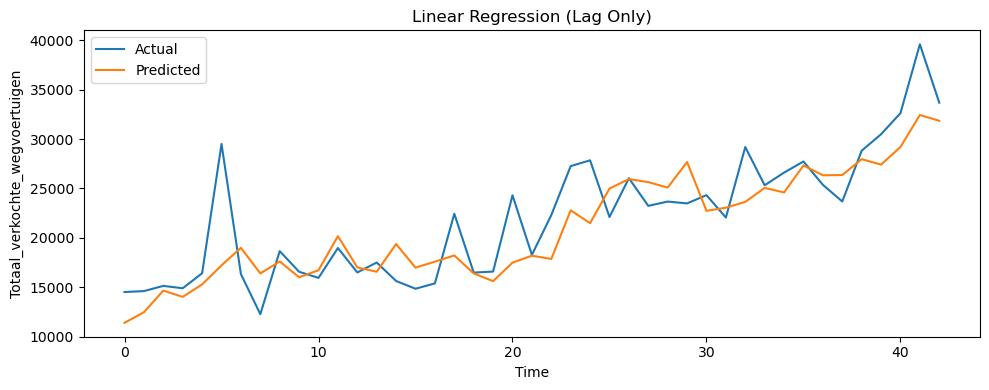

Linear Regression (All Features): MAPE=0.1548, MAE=3386.96, RMSE=4441.61, R²=0.493


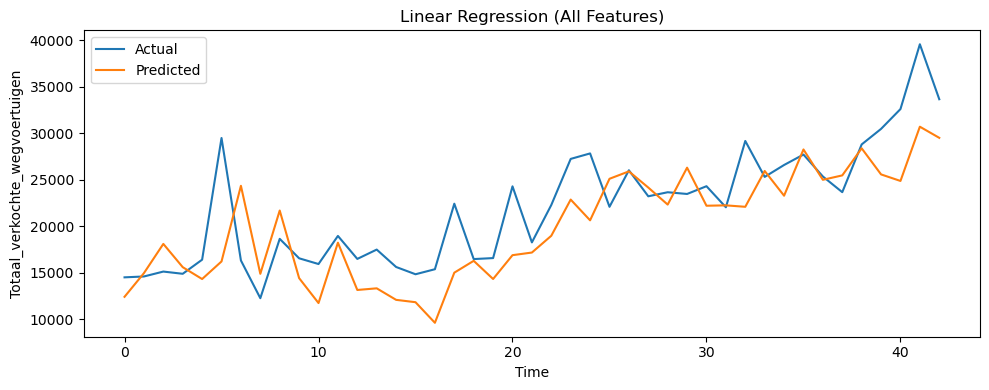

In [43]:
for label, features in feature_sets.items():
	mae, rmse, r2, mape, preds, actuals = walk_forward_validation(
		df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression())
	print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
	plt.figure(figsize=(10, 4))
	plt.plot(actuals, label='Actual')
	plt.plot(preds, label='Predicted')
	plt.xlabel('Time')
	plt.ylabel('Totaal_verkochte_wegvoertuigen')
	plt.title(f'Linear Regression ({label})')
	plt.legend()
	plt.tight_layout()
	plt.show()

Linear Regression (Lag Only): MAPE=0.1133, MAE=2537.26, RMSE=3483.25, R²=0.688


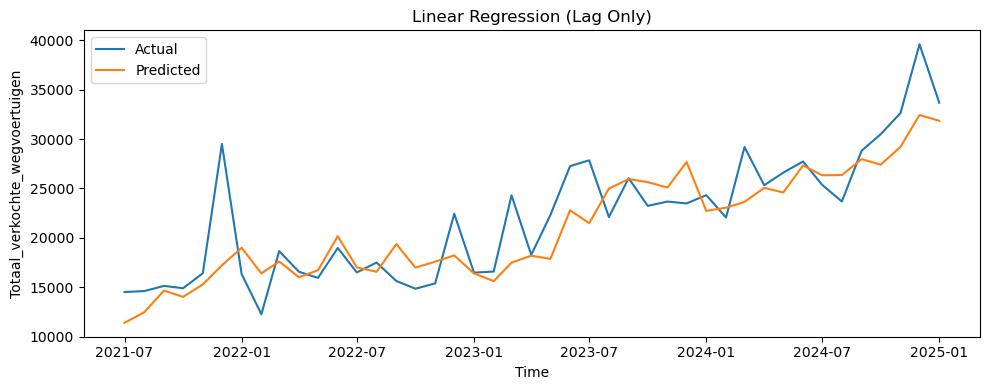

Linear Regression (All Features): MAPE=0.1548, MAE=3386.96, RMSE=4441.61, R²=0.493


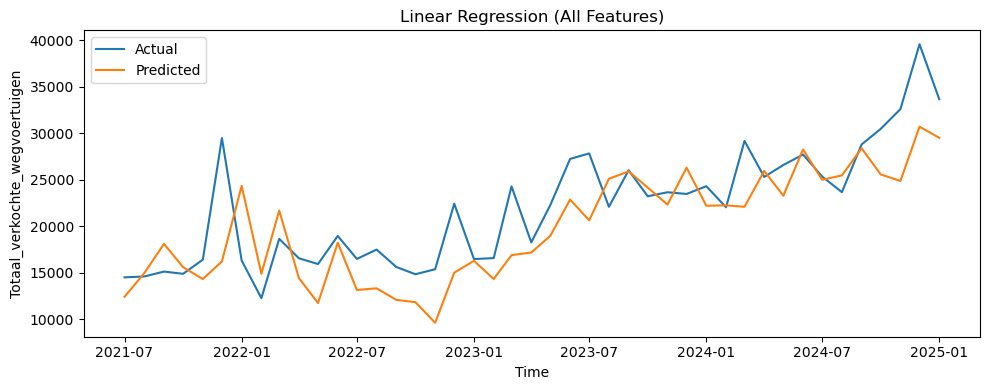

In [44]:
# Get the corresponding dates for the test set
test_dates = df_lagged['Periode'].iloc[-len(actuals):]

for label, features in feature_sets.items():
	mae, rmse, r2, mape, preds, actuals = walk_forward_validation(
		df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression())
	print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
	plt.figure(figsize=(10, 4))
	plt.plot(test_dates, actuals, label='Actual')
	plt.plot(test_dates, preds, label='Predicted')
	plt.xlabel('Time')
	plt.ylabel('Totaal_verkochte_wegvoertuigen')
	plt.title(f'Linear Regression ({label})')
	plt.legend()
	plt.tight_layout()
	plt.show()

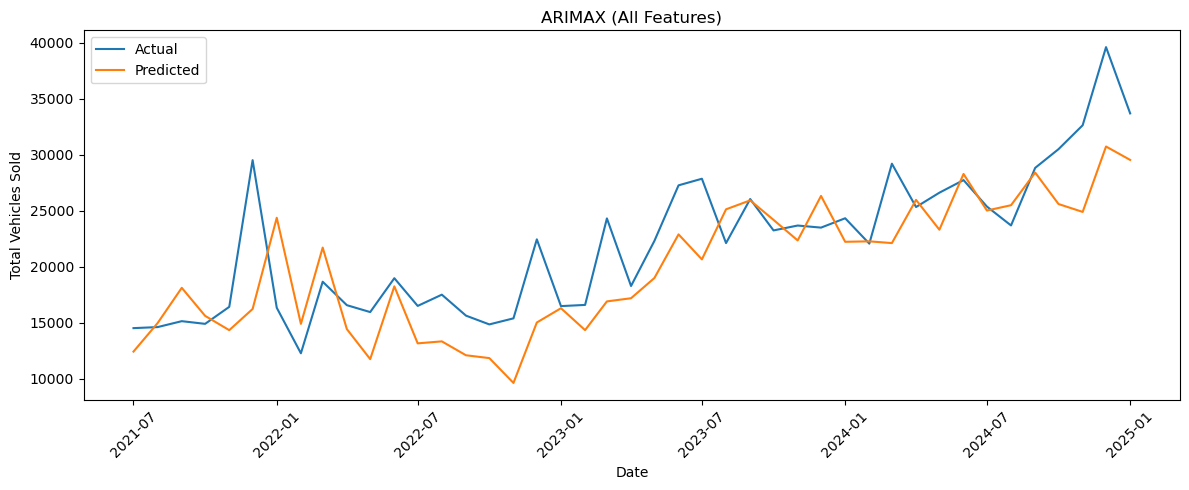

In [45]:
# Plot ARIMAX (All Features) predictions vs actuals with dates on the x-axis
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actuals, label='Actual')
plt.plot(test_dates, preds, label='Predicted')
plt.title('ARIMAX (All Features)')
plt.xlabel('Date')
plt.ylabel('Total Vehicles Sold')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

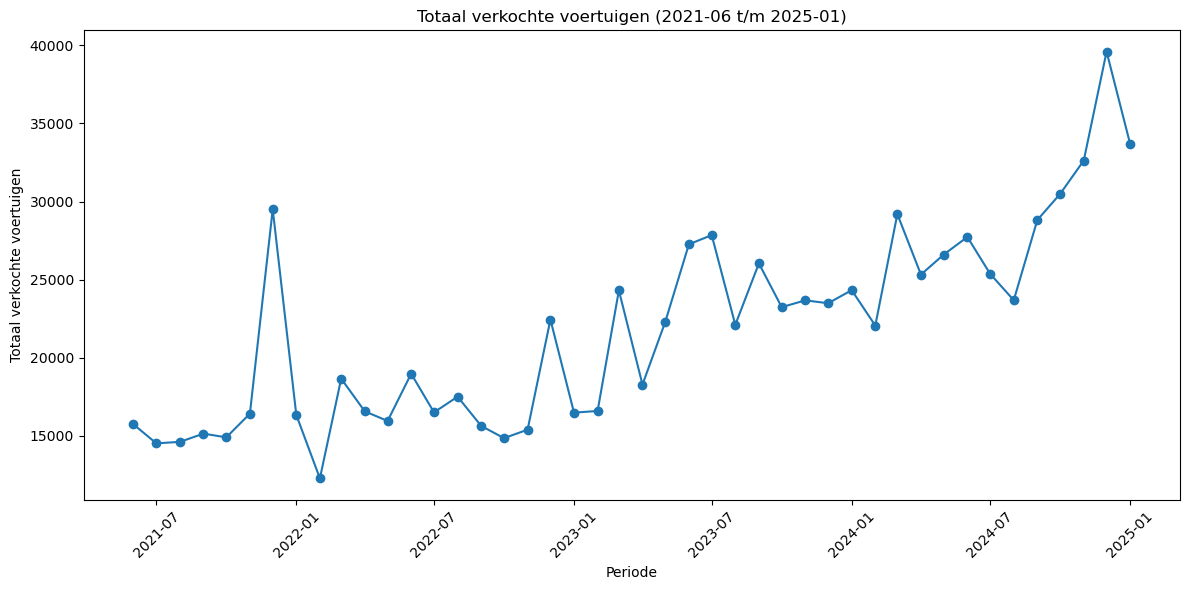

In [23]:
# Plot 'Totaal_verkochte_wegvoertuigen' from 2021-06 until 2025-01
mask = (df['Periode'] >= '2021-06-01') & (df['Periode'] <= '2025-01-01')
plt.figure(figsize=(12, 6))
plt.plot(df.loc[mask, 'Periode'], df.loc[mask, 'Totaal_verkochte_wegvoertuigen'], marker='o')
plt.title('Totaal verkochte voertuigen (2021-06 t/m 2025-01)')
plt.xlabel('Periode')
plt.ylabel('Totaal verkochte voertuigen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ElasticNet: Lag Only vs All Features

ElasticNet (Lag Only): MAPE=0.1158, MAE=2594.05, RMSE=3558.88, R²=0.674


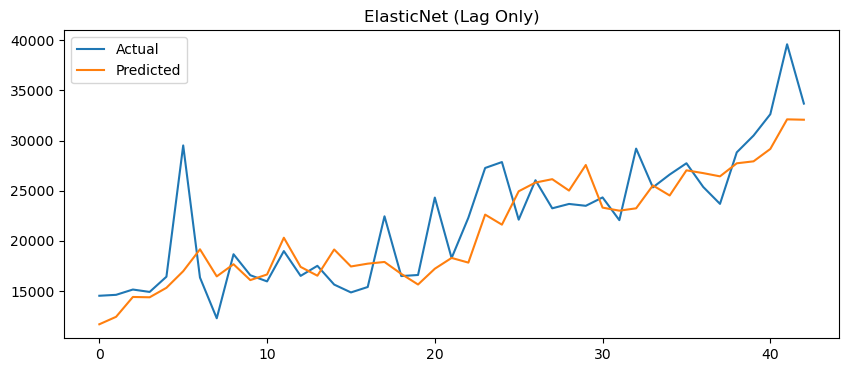

ElasticNet (All Features): MAPE=0.1272, MAE=2942.97, RMSE=4227.54, R²=0.540


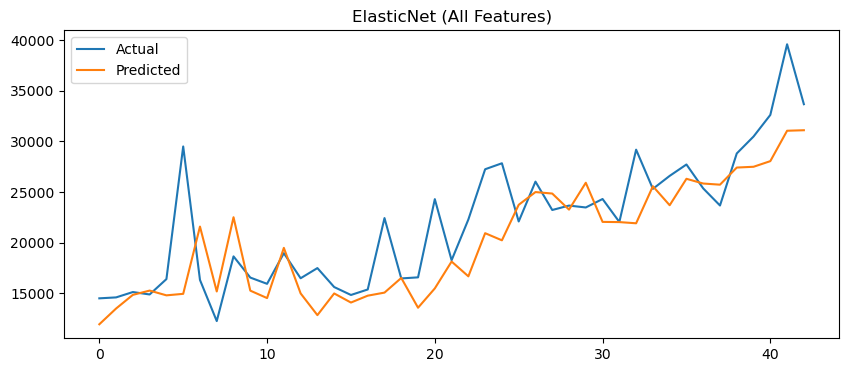

In [29]:
for label, features in feature_sets.items():
    mae, rmse, r2, mape, preds, actuals = walk_forward_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=42))
    print(f"ElasticNet ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(actuals, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(f'ElasticNet ({label})')
    plt.legend()
    plt.show()

## XGBoost: Lag Only vs All Features

XGBoost (Lag Only): MAPE=0.1172, MAE=2623.66, RMSE=3467.32, R²=0.691


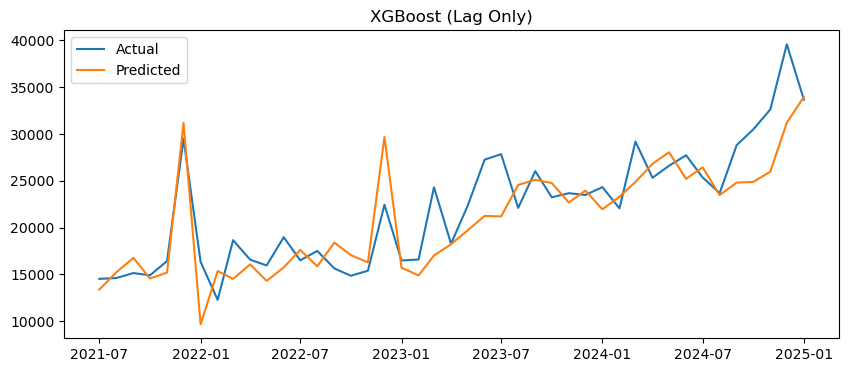

XGBoost (All Features): MAPE=0.1127, MAE=2654.32, RMSE=3758.81, R²=0.637


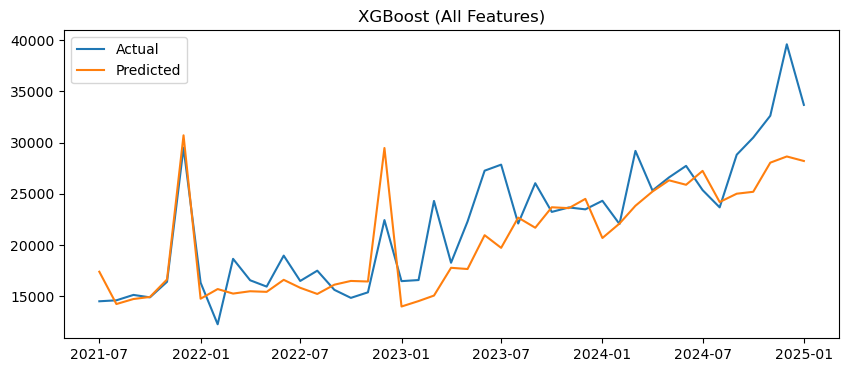

In [55]:
for label, features in feature_sets.items():
    mae, rmse, r2, mape, preds, actuals = walk_forward_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"))
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals, label='Actual')
    plt.plot(test_dates, preds, label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.show()

## ARIMA/ARIMAX (Univariate/Multivariate)

ARIMA: MAPE=12.2333, MAE=2859.26, RMSE=4172.10, R²=0.552


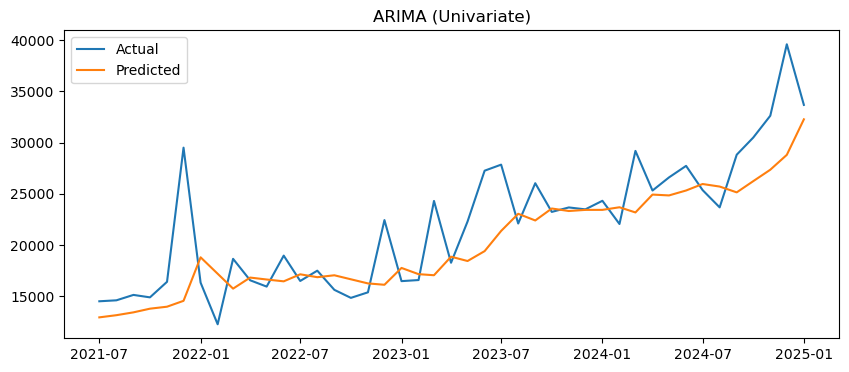

In [46]:
def walk_forward_arima(df, target_col, order=(1,1,1), forecast_horizon=1):
    y = df[target_col].values
    initial_train_size = int(len(df) * 0.8)
    predictions, actuals = [], []
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        train_y = y[:i]
        test_y = y[i + forecast_horizon - 1]
        model = ARIMA(train_y, order=order)
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=forecast_horizon)[-1]
        predictions.append(y_pred)
        actuals.append(test_y)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    return mae, rmse, r2, mape, predictions, actuals

mae, rmse, r2, mape, preds, actuals = walk_forward_arima(df_lagged, 'Totaal_verkochte_wegvoertuigen')
print(f"ARIMA: MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(test_dates, actuals, label='Actual')
plt.plot(test_dates, preds, label='Predicted')
plt.title('ARIMA (Univariate)')
plt.legend()
plt.show()

ARIMAX: MAPE=257.91%, MAE=48494.4737, RMSE=88049.38, R²=-198.435


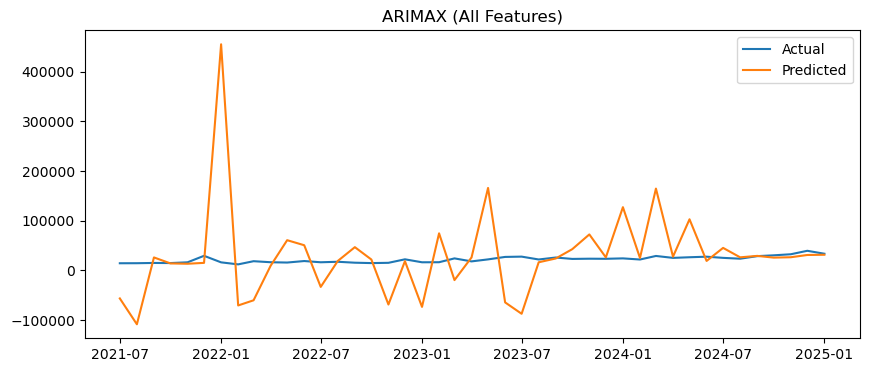

In [47]:



def walk_forward_arimax(df, target_col, exog_cols, order=(1,1,1), forecast_horizon=1):
    y = df[target_col].values
    X = df[exog_cols].values
    initial_train_size = int(len(df) * 0.8)
    predictions, actuals = [], []
    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        train_y = y[:i]
        train_X = X[:i]
        test_X = X[i:i + forecast_horizon]
        test_y = y[i + forecast_horizon - 1]
        model = SARIMAX(train_y, exog=train_X, order=order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=forecast_horizon, exog=test_X)[-1]
        predictions.append(y_pred)
        actuals.append(test_y)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    return mae, rmse, r2, mape, predictions, actuals

mae, rmse, r2, mape, preds, actuals = walk_forward_arimax(df_lagged, 'Totaal_verkochte_wegvoertuigen', feature_sets['All Features'])
print(f"ARIMAX: MAPE={mape:.2f}%, MAE={mae:.4f}, RMSE={rmse:.2f}, R²={r2:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(test_dates, actuals, label='Actual')
plt.plot(test_dates, preds, label='Predicted')
plt.title('ARIMAX (All Features)')
plt.legend()
plt.show()

In [17]:
print(actuals)

[14522 14615 15143 14904 16421 29509 16338 12278 18662 16571 15954 18977
 16504 17508 15637 14854 15395 22443 16487 16593 24311 18281 22305 27262
 27851 22109 26040 23240 23676 23490 24325 22060 29193 25326 26607 27731
 25370 23683 28820 30491 32623 39594 33680]


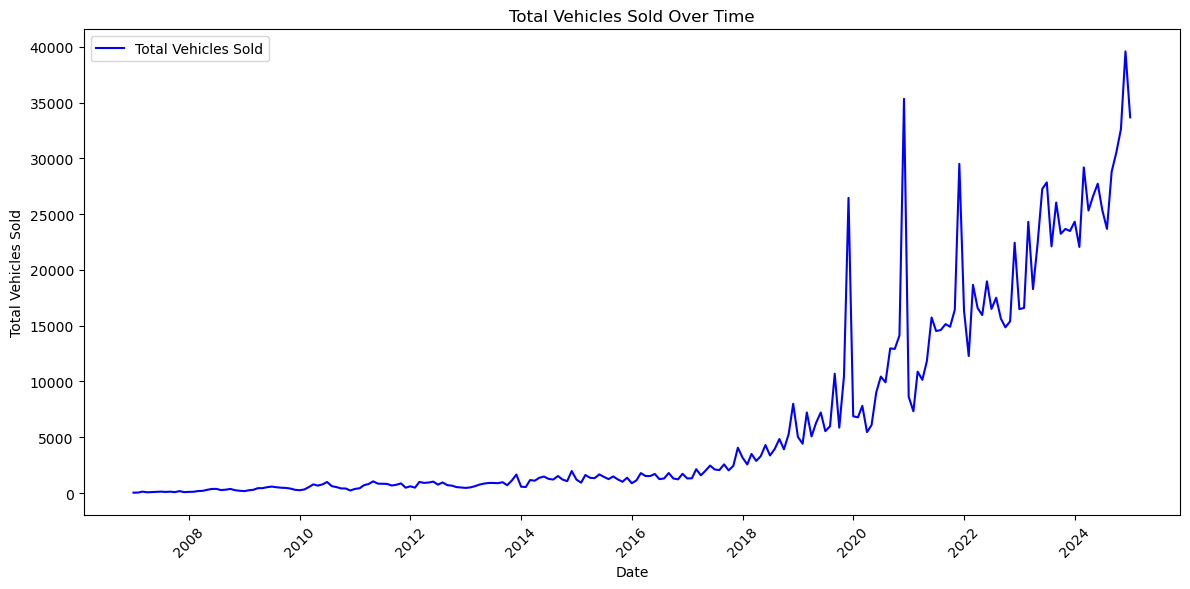

In [18]:
# Plt full dataset
plt.figure(figsize=(12, 6))
plt.plot(df['Periode'], df['Totaal_verkochte_wegvoertuigen'], label='Total Vehicles Sold', color='blue')
plt.title('Total Vehicles Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Vehicles Sold')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Notes
- All models use expanding window walk-forward validation.
- Compare metrics and plots to assess the impact of feature selection and model choice.
- For further improvement: tune hyperparameters, engineer new features, or try other model types.

In [53]:
from skopt import BayesSearchCV

# Define search space for XGBoost
search_spaces = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (2, 8),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

results = {}
for label, features in feature_sets.items():
    X = df_lagged[features].values
    y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

    n = len(df_lagged)
    initial_train_size = int(n * 0.8)
    val_size = int(initial_train_size * 0.1)
    train_size = initial_train_size - val_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:initial_train_size], y[train_size:initial_train_size]

    # Custom split for time series
    cv = [(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_val)))]

    X_search = np.concatenate([X_train, X_val], axis=0)
    y_search = np.concatenate([y_train, y_val], axis=0)

    opt = BayesSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric="rmse"),
        search_spaces,
        n_iter=25,
        cv=cv,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,
        verbose=0,
        refit=True
    )
    opt.fit(X_search, y_search)
    print(f"Best parameters for {label}:", opt.best_params_)
    print(f"Best MAPE on validation split for {label}: {abs(opt.best_score_):.4f}")
    results[label] = (opt.best_params_, abs(opt.best_score_))


Best parameters for Lag Only: OrderedDict({'colsample_bytree': 0.625687553151006, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 171, 'subsample': 0.5})
Best MAPE on validation split for Lag Only: 0.2648
Best parameters for All Features: OrderedDict({'colsample_bytree': 0.5, 'learning_rate': 0.01286315525801749, 'max_depth': 2, 'n_estimators': 260, 'subsample': 0.5})
Best MAPE on validation split for All Features: 0.2461


### Split

In [ ]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [54]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression # Voorbeeldmodel, je kunt elke scikit-learn compatibele model_fn gebruiken
 
def walk_forward_validation_with_validation_set(df, features, target_col, model_fn, forecast_horizon=1, validation_size=None):

    """

    Voert walk-forward validatie uit met een expliciete validatieset en expanding window splits.
 
    Parameters:

    df (pd.DataFrame): De dataframe met de features en de target kolom.

    features (list): Een lijst met kolomnamen die als features worden gebruikt.

    target_col (str): De naam van de kolom die als target wordt gebruikt.

    model_fn (callable): Een functie die een nieuw, ongefit model object retourneert (bijv. lambda: LinearRegression()).

    forecast_horizon (int): Het aantal stappen vooruit dat voorspeld moet worden. Standaard is 1.

    validation_size (int, optional): Het aantal observaties in de validatieset voor elke split.

                                     Als None, wordt de validatieset overgeslagen en werkt het als de originele walk-forward.
 
    Returns:

    tuple: Een tuple met (mae, rmse, r2, mape, test_predictions, test_actuals, validation_predictions, validation_actuals).

           Als validation_size None is, zijn validation_predictions en validation_actuals lege lijsten.

    """

    X = df[features].values

    y = df[target_col].values
 
    # Bepaal de initiële grootte van de trainingsset.

    # Dit is het punt waar de eerste split begint.

    # We zorgen ervoor dat er voldoende data overblijft voor validatie en testen.

    if validation_size is not None:

        # Zorg voor minimaal 1 observatie in validatie en test

        min_initial_train_size = forecast_horizon + validation_size

    else:

        min_initial_train_size = forecast_horizon
 
    # Een redelijke initiële trainingsgrootte, bijv. 80% van de data om mee te starten

    initial_train_size = max(int(len(df) * 0.8), min_initial_train_size)
 
    test_predictions, test_actuals = [], []

    validation_predictions, validation_actuals = [], []
 
    # De loop start vanaf de initiële trainingsgrootte

    # en gaat door zolang er genoeg data is voor de testset (forecast_horizon)

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):

        # Definiëren van de trainingsset (Expanding Window)

        X_train, y_train = X[:i], y[:i]
 
        # Definiëren van de validatieset

        if validation_size is not None:

            # De validatieset begint direct na de trainingsset

            # en heeft de lengte van 'validation_size'

            X_val = X[i : i + validation_size]

            y_val = y[i : i + validation_size]
 
            # Zorg ervoor dat er voldoende data is voor zowel validatie als test

            # Als er niet genoeg data is voor zowel validatie als test, sla dan deze iteratie over

            if (i + validation_size + forecast_horizon - 1) >= len(df):

                break # Niet genoeg data voor de volledige validatie- en testsets
 
            # Definiëren van de testset

            # De testset begint na de validatieset en heeft de lengte van forecast_horizon

            X_test = X[i + validation_size : i + validation_size + forecast_horizon]

            y_test = y[i + validation_size : i + validation_size + forecast_horizon]

        else:

            # Als er geen validatieset is, begint de testset direct na de trainingsset

            X_test = X[i : i + forecast_horizon]

            y_test = y[i : i + forecast_horizon]
 
            # Zorg ervoor dat er genoeg data is voor de testset

            if (i + forecast_horizon - 1) >= len(df):

                break
 
        # Initialiseer en train het model

        model = model_fn()

        model.fit(X_train, y_train)
 
        # Voorspellingen op de validatieset (indien aanwezig)

        if validation_size is not None:

            if len(X_val) > 0: # Zorg ervoor dat de validatieset niet leeg is

                val_preds = model.predict(X_val)

                validation_predictions.extend(val_preds)

                validation_actuals.extend(y_val)
 
        # Voorspellingen op de testset

        if len(X_test) > 0: # Zorg ervoor dat de testset niet leeg is

            test_preds = model.predict(X_test)

            test_predictions.extend(test_preds)

            test_actuals.extend(y_test)
 
    # Converteer lijsten naar NumPy arrays

    test_predictions = np.array(test_predictions)

    test_actuals = np.array(test_actuals)

    validation_predictions = np.array(validation_predictions)

    validation_actuals = np.array(validation_actuals)
 
    # Bereken metrics voor de testset

    if len(test_actuals) > 0:

        mae = mean_absolute_error(test_actuals, test_predictions)

        rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))

        r2 = r2_score(test_actuals, test_predictions)

        mape = mean_absolute_percentage_error(test_actuals, test_predictions)

    else:

        mae, rmse, r2, mape = np.nan, np.nan, np.nan, np.nan # Geen testresultaten
 
    # Bereken metrics voor de validatieset (indien aanwezig)

    val_mae, val_rmse, val_r2, val_mape = np.nan, np.nan, np.nan, np.nan

    if validation_size is not None and len(validation_actuals) > 0:

        val_mae = mean_absolute_error(validation_actuals, validation_predictions)

        val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))

        val_r2 = r2_score(validation_actuals, validation_predictions)

        val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)
 
    return (mae, rmse, r2, mape, test_predictions, test_actuals,

            val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals)
 
 


In [68]:
def walk_forward_validation_with_validation_set(
    df, features, target_col, model_fn, forecast_horizon=1, validation_size=None
):
    """
    Voert walk-forward validatie uit met een expliciete validatieset en expanding window splits.
    Returns:
        tuple: (mae, rmse, r2, mape, test_predictions, test_actuals, test_dates,
                val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, val_dates)
    """
    X = df[features].values
    y = df[target_col].values

    # Dates for plotting
    dates = df['Periode'].values if 'Periode' in df.columns else np.arange(len(df))

    if validation_size is not None:
        min_initial_train_size = forecast_horizon + validation_size
    else:
        min_initial_train_size = forecast_horizon

    initial_train_size = max(int(len(df) * 0.8), min_initial_train_size)

    test_predictions, test_actuals, test_dates = [], [], []
    validation_predictions, validation_actuals, val_dates = [], [], []

    for i in range(initial_train_size, len(df) - forecast_horizon + 1):
        X_train, y_train = X[:i], y[:i]

        if validation_size is not None:
            X_val = X[i : i + validation_size]
            y_val = y[i : i + validation_size]
            val_date = dates[i : i + validation_size]

            if (i + validation_size + forecast_horizon - 1) >= len(df):
                break

            X_test = X[i + validation_size : i + validation_size + forecast_horizon]
            y_test = y[i + validation_size : i + validation_size + forecast_horizon]
            test_date = dates[i + validation_size : i + validation_size + forecast_horizon]
        else:
            X_test = X[i : i + forecast_horizon]
            y_test = y[i : i + forecast_horizon]
            test_date = dates[i : i + forecast_horizon]

            if (i + forecast_horizon - 1) >= len(df):
                break

        model = model_fn()
        model.fit(X_train, y_train)

        if validation_size is not None and len(X_val) > 0:
            val_preds = model.predict(X_val)
            validation_predictions.extend(val_preds)
            validation_actuals.extend(y_val)
            val_dates.extend(val_date)

        if len(X_test) > 0:
            test_preds = model.predict(X_test)
            test_predictions.extend(test_preds)
            test_actuals.extend(y_test)
            test_dates.extend(test_date)

    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)
    test_dates = np.array(test_dates)

    validation_predictions = np.array(validation_predictions)
    validation_actuals = np.array(validation_actuals)
    val_dates = np.array(val_dates)

    if len(test_actuals) > 0:
        mae = mean_absolute_error(test_actuals, test_predictions)
        rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
        r2 = r2_score(test_actuals, test_predictions)
        mape = mean_absolute_percentage_error(test_actuals, test_predictions)
    else:
        mae, rmse, r2, mape = np.nan, np.nan, np.nan, np.nan

    val_mae, val_rmse, val_r2, val_mape = np.nan, np.nan, np.nan, np.nan
    if validation_size is not None and len(validation_actuals) > 0:
        val_mae = mean_absolute_error(validation_actuals, validation_predictions)
        val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))
        val_r2 = r2_score(validation_actuals, validation_predictions)
        val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)

    return (
        mae, rmse, r2, mape, test_predictions, test_actuals, test_dates,
        val_mae, val_rmse, val_r2, val_mape, validation_predictions, validation_actuals, val_dates
    )

XGBOOST

XGBoost (Lag Only): MAPE=0.1172, MAE=2623.66, RMSE=3467.32, R²=0.691


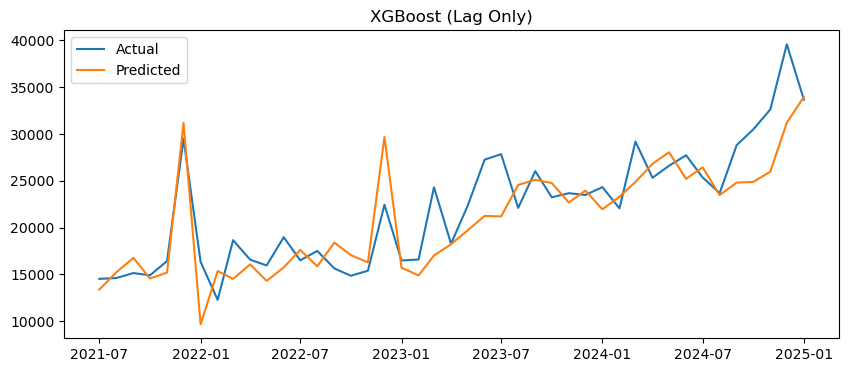

XGBoost (All Features): MAPE=0.1127, MAE=2654.32, RMSE=3758.81, R²=0.637


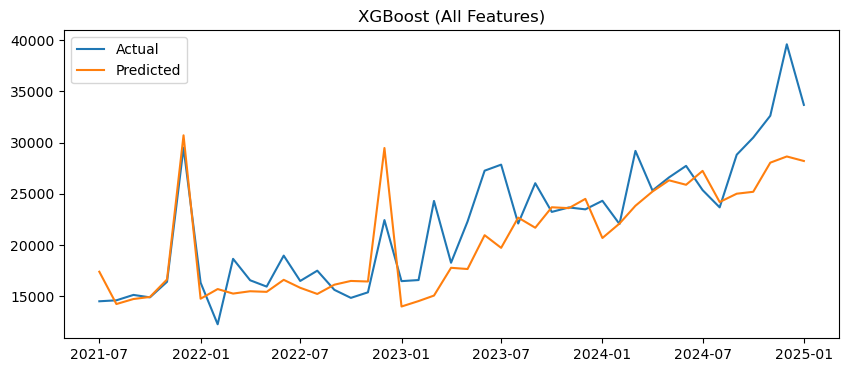

In [71]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals, test_dates,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, val_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse")
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    # Add results to list for summary table
    summary_results.append({
        "Model": f"XGBoost ({label})",
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape * 100
    })
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals, label='Actual')
    plt.plot(test_dates, preds, label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.show()

### Linear regression 

Linear Regression (Lag Only): MAPE=0.1133, MAE=2537.26, RMSE=3483.25, R²=0.688


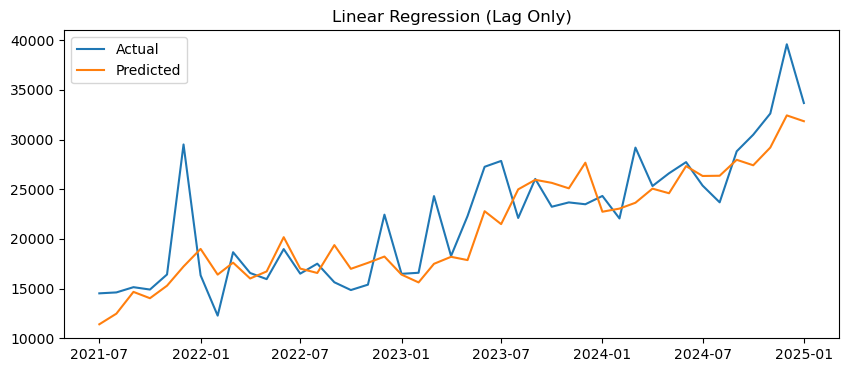

Linear Regression (All Features): MAPE=0.1548, MAE=3386.96, RMSE=4441.61, R²=0.493


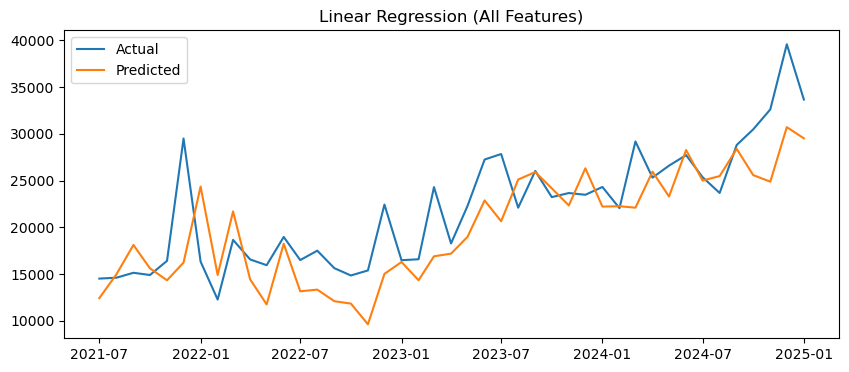

In [73]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals, test_dates,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, val_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', lambda: LinearRegression()
    )
    print(f"Linear Regression ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    # Add results to list for summary table
    summary_results.append({
        "Model": f"Linear Regression ({label})",
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape * 100
    })
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals, label='Actual')
    plt.plot(test_dates, preds, label='Predicted')
    plt.title(f'Linear Regression ({label})')
    plt.legend()
    plt.show()

### Arima 

ARIMA (Validation): MAPE=0.2829, MAE=3763.03, RMSE=6912.99, R²=-0.072


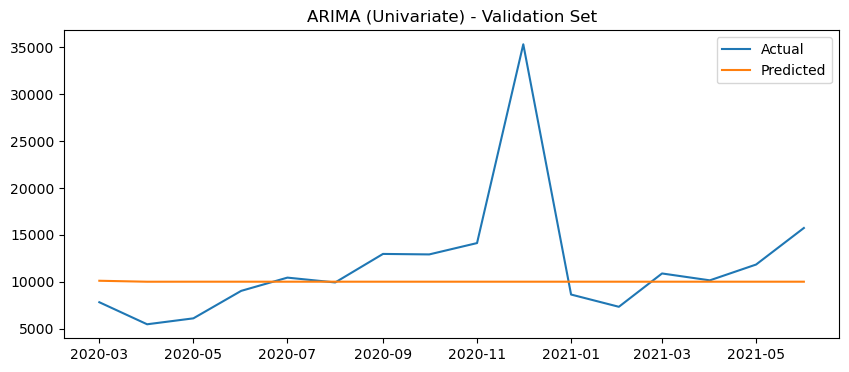

In [77]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Use same validation split as ARIMAX
n = len(df_lagged)
initial_train_size = int(n * 0.8)
val_size = int(initial_train_size * 0.1)
train_size = initial_train_size - val_size

val_idx = np.arange(train_size, initial_train_size)
val_dates = df_lagged['Periode'].iloc[val_idx]
val_actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].iloc[val_idx]

# Fit ARIMA on train, predict on validation
train_y = df_lagged['Totaal_verkochte_wegvoertuigen'].iloc[:train_size]

model = ARIMA(train_y, order=(1,1,1))
model_fit = model.fit()
val_preds = model_fit.forecast(steps=val_size)

val_mae = mean_absolute_error(val_actuals, val_preds)
val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
val_r2 = r2_score(val_actuals, val_preds)
val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

print(f"ARIMA (Validation): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(val_dates, val_actuals, label='Actual')
plt.plot(val_dates, val_preds, label='Predicted')
plt.title('ARIMA (Univariate) - Validation Set')
plt.legend()
plt.show()

### Arimax 

ARIMAX (Lag Only, Validation): MAPE=1.1669, MAE=11336.06, RMSE=16884.51, R²=-5.397


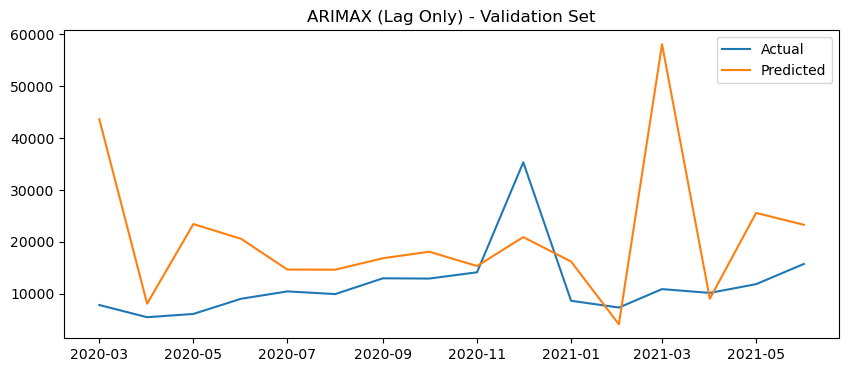

In [78]:
# Use ARIMAX on only lagged features for validation set

# Prepare lagged features
lagged_features = feature_sets['Lag Only']

train_X_lag = df_lagged[lagged_features].iloc[:train_size]
val_X_lag = df_lagged[lagged_features].iloc[val_idx]

# Fit ARIMAX on train, predict on validation (lagged features only)
model_lag = SARIMAX(train_y, exog=train_X_lag, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
model_fit_lag = model_lag.fit(disp=False)
val_preds_lag = model_fit_lag.forecast(steps=val_size, exog=val_X_lag)

val_mae_lag = mean_absolute_error(val_actuals, val_preds_lag)
val_rmse_lag = np.sqrt(mean_squared_error(val_actuals, val_preds_lag))
val_r2_lag = r2_score(val_actuals, val_preds_lag)
val_mape_lag = mean_absolute_percentage_error(val_actuals, val_preds_lag)

print(f"ARIMAX (Lag Only, Validation): MAPE={val_mape_lag:.4f}, MAE={val_mae_lag:.2f}, RMSE={val_rmse_lag:.2f}, R²={val_r2_lag:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(val_dates, val_actuals, label='Actual')
plt.plot(val_dates, val_preds_lag, label='Predicted')
plt.title('ARIMAX (Lag Only) - Validation Set')
plt.legend()
plt.show()


ARIMAX (Validation): MAPE=1.0946, MAE=10649.34, RMSE=16186.94, R²=-4.879


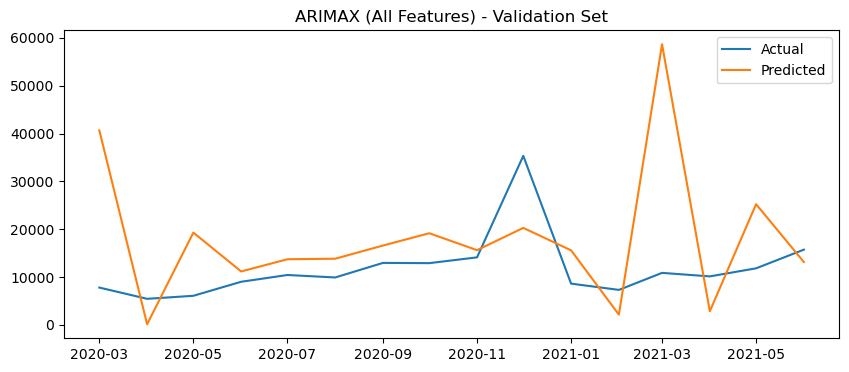

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Determine validation size as used in previous cells (10% of initial train size)
n = len(df_lagged)
initial_train_size = int(n * 0.8)
val_size = int(initial_train_size * 0.1)
train_size = initial_train_size - val_size

# Indices for splits
val_idx = np.arange(train_size, initial_train_size)
val_dates = df_lagged['Periode'].iloc[val_idx]
val_actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].iloc[val_idx]

# Fit ARIMAX on train, predict on validation

train_y = df_lagged['Totaal_verkochte_wegvoertuigen'].iloc[:train_size]
train_X = df_lagged[feature_sets['All Features']].iloc[:train_size]
val_X = df_lagged[feature_sets['All Features']].iloc[val_idx]

model = SARIMAX(train_y, exog=train_X, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
val_preds = model_fit.forecast(steps=val_size, exog=val_X)


val_mae = mean_absolute_error(val_actuals, val_preds)
val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
val_r2 = r2_score(val_actuals, val_preds)
val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

print(f"ARIMAX (Validation): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(val_dates, val_actuals, label='Actual')
plt.plot(val_dates, val_preds, label='Predicted')
plt.title('ARIMAX (All Features) - Validation Set')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [80]:
from skopt import BayesSearchCV

# Use only lagged features for optimization
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

X = df_lagged[lagged_features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

n = len(df_lagged)
initial_train_size = int(n * 0.8)
val_size = int(initial_train_size * 0.1)
train_size = initial_train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:initial_train_size], y[train_size:initial_train_size]

cv = [(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_val)))]

X_search = np.concatenate([X_train, X_val], axis=0)
y_search = np.concatenate([y_train, y_val], axis=0)

search_spaces = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'max_depth': (2, 8),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

opt_lag = BayesSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric="rmse"),
    search_spaces,
    n_iter=25,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=0,
    refit=True
)
opt_lag.fit(X_search, y_search)
print("Best parameters (Lag Only):", opt_lag.best_params_)
print(f"Best MAPE on validation split (Lag Only): {abs(opt_lag.best_score_):.4f}")

Best parameters (Lag Only): OrderedDict({'colsample_bytree': 0.5620339899253772, 'learning_rate': 0.021413698983469787, 'max_depth': 6, 'n_estimators': 95, 'subsample': 0.7031022992562256})
Best MAPE on validation split (Lag Only): 0.3074


XGBoost (Lag Only): MAPE=0.2034, MAE=4759.94, RMSE=5800.08, R²=0.135


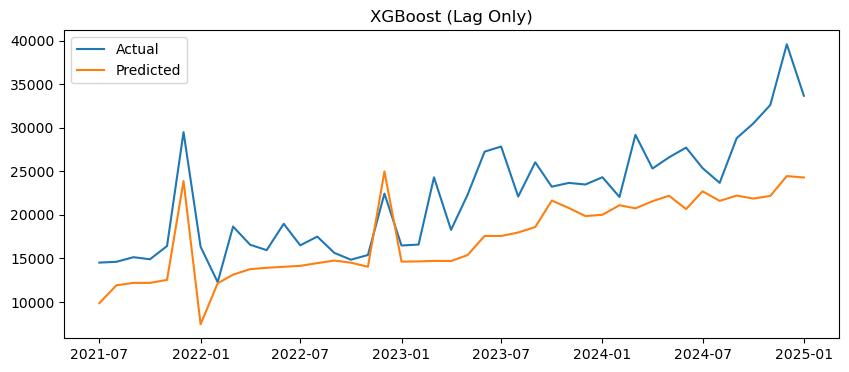

XGBoost (All Features): MAPE=0.2217, MAE=5177.09, RMSE=6221.71, R²=0.004


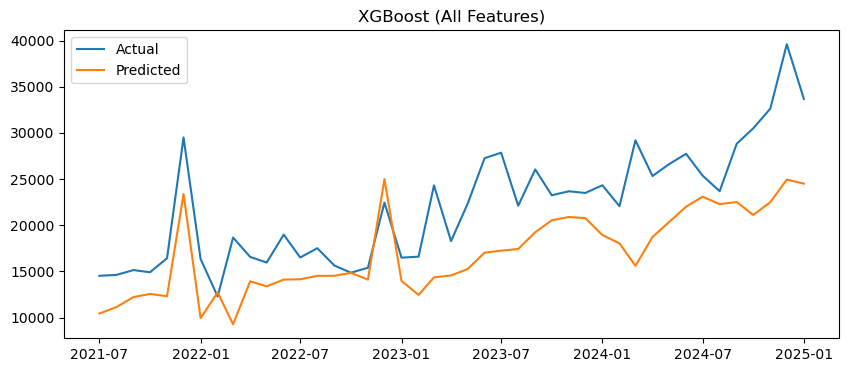

In [82]:
for label, features in feature_sets.items():
    (
        mae, rmse, r2, mape, preds, actuals, test_dates,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, val_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=95, learning_rate=0.021413698983469787, max_depth=6, random_state=42, eval_metric="rmse")
    )
    print(f"XGBoost ({label}): MAPE={mape:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    # Add results to list for summary table
    summary_results.append({
        "Model": f"XGBoost ({label})",
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape * 100
    })
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, actuals, label='Actual')
    plt.plot(test_dates, preds, label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.show()

In [81]:
# Use all features for optimization
X = df_lagged[features].values
y = df_lagged['Totaal_verkochte_wegvoertuigen'].values

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:initial_train_size], y[train_size:initial_train_size]

cv = [(np.arange(len(X_train)), np.arange(len(X_train), len(X_train) + len(X_val)))]

X_search = np.concatenate([X_train, X_val], axis=0)
y_search = np.concatenate([y_train, y_val], axis=0)

opt_all = BayesSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric="rmse"),
    search_spaces,
    n_iter=25,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=0,
    refit=True
)
opt_all.fit(X_search, y_search)
print("Best parameters (All Features):", opt_all.best_params_)
print(f"Best MAPE on validation split (All Features): {abs(opt_all.best_score_):.4f}")


Best parameters (All Features): OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.02565433522731517, 'max_depth': 2, 'n_estimators': 112, 'subsample': 0.5})
Best MAPE on validation split (All Features): 0.2653


### Arimax

In [ ]:
# Use ARIMAX on only lagged features for validation set

# Prepare lagged features
lagged_features = feature_sets['Lag Only']

train_X_lag = df_lagged[lagged_features].iloc[:train_size]
val_X_lag = df_lagged[lagged_features].iloc[val_idx]

# Fit ARIMAX on train, predict on validation (lagged features only)
model_lag = SARIMAX(train_y, exog=train_X_lag, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
model_fit_lag = model_lag.fit(disp=False)
val_preds_lag = model_fit_lag.forecast(steps=val_size, exog=val_X_lag)

val_mae_lag = mean_absolute_error(val_actuals, val_preds_lag)
val_rmse_lag = np.sqrt(mean_squared_error(val_actuals, val_preds_lag))
val_r2_lag = r2_score(val_actuals, val_preds_lag)
val_mape_lag = mean_absolute_percentage_error(val_actuals, val_preds_lag)

print(f"ARIMAX (Lag Only, Validation): MAPE={val_mape_lag:.4f}, MAE={val_mae_lag:.2f}, RMSE={val_rmse_lag:.2f}, R²={val_r2_lag:.3f}")
plt.figure(figsize=(10, 4))
plt.plot(val_dates, val_actuals, label='Actual')
plt.plot(val_dates, val_preds_lag, label='Predicted')
plt.title('ARIMAX (Lag Only) - Validation Set')
plt.legend()
plt.show()
